<a href="https://colab.research.google.com/github/annisakrnn/Machine-Learning_2025/blob/main/TG6_2341720070_ANNISA_KURNIAWATI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1

Instalasi Annoy dulu untuk langkah awal.

In [1]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551809 sha256=73faeb563d46368d7699607ed1e58cfa3f9f8c2839355c3c80a56c9d6ed7d354
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


Langkah 1

Membandingkan dua pendekatan pencarian tetangga terdekat (Nearest Neighbor atau NN) pada dataset sederhana
*   Metode Exact NN (brute force): Pendekatan akurat tapi lambat, yang menghitung jarak ke semua titik secara eksplisit.
*   Metode Approximate NN menggunakan Annoy: Pendekatan cepat tapi kurang akurat (aproksimasi), yang menggunakan struktur pohon (trees) untuk mempercepat pencarian.

Kesimpulan:

Kode dibawah mengahasilkan bahwa annoy bisa mempercepat pencarian NN hingga 10-100x dibanding brute force, dengan sedikit pengorbanan akurasi (recall >95% biasanya). Cocok untuk dataset besar (jutaan titik) di aplikasi real-time namun kelemahanya memawakn waktu dan memori cukup besar.



Euclidean

Exact NN index: [64040 64186 88792]
Exact NN jarak: [0.         0.15797867 0.25332711]
Waktu Exact: 19.0794 ms

Annoy NN index: [64040, 64186, 88792]
Annoy NN jarak: [np.float64(0.0), np.float64(0.1579786703429142), np.float64(0.2533271079062769)]
Waktu Annoy: 0.2425 ms


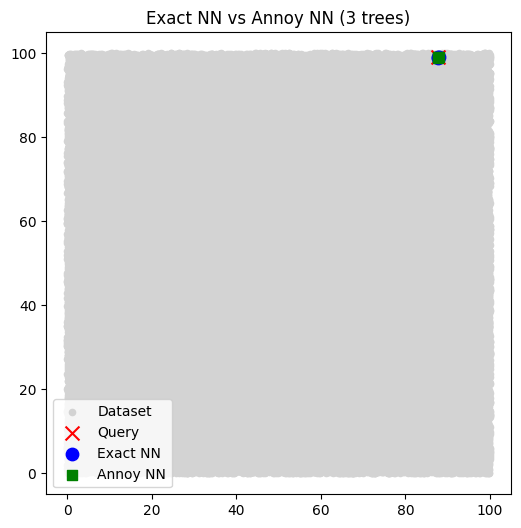

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 100000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

Angular

Exact NN index: [64040  1310  1267]
Exact NN jarak (angular): [2.22044605e-16 6.23343599e-11 7.57095497e-11]
Waktu Exact: 11.2152 ms

Annoy NN index: [64040, 1310, 9720]
Annoy NN jarak (angular): [np.float64(2.220446049250313e-16), np.float64(6.233435989599911e-11), np.float64(6.8060926894375484e-09)]
Waktu Annoy: 0.123 ms


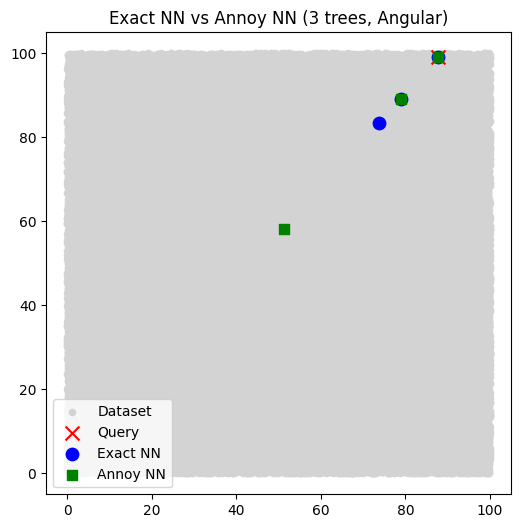

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 100000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random) - saran: ganti ke X[0] untuk konsistensi
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force) - DIRUBAH: Gunakan angular distance (1 - cosine sim)
start = time.time()
cos_sim = np.dot(X, query) / (np.linalg.norm(X, axis=1) * np.linalg.norm(query))
distances = 1 - cos_sim  # Angular distance
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak (angular):", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree) - DIRUBAH: Gunakan 'angular' metric
f = 2  # dimensi
t = AnnoyIndex(f, 'angular')  # Ubah ke 'angular'
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

# Hitung jarak Annoy untuk verifikasi (angular)
ann_dist = [1 - (np.dot(X[i], query) / (np.linalg.norm(X[i]) * np.linalg.norm(query))) for i in idx_ann]

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak (angular):", ann_dist)
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil (tetap sama, karena plot Euclidean-based)
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees, Angular)")
plt.show()

Hasil :

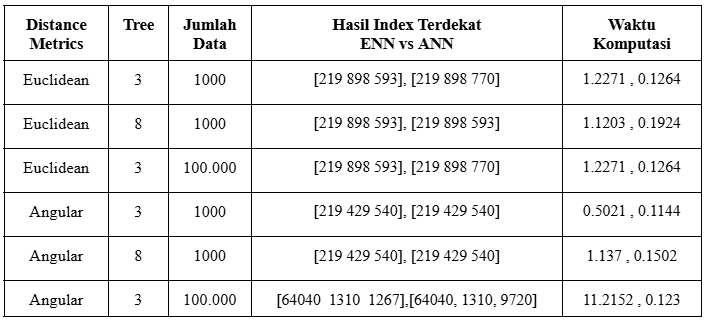

Percobaan simulasi membuat track rekomendasi spotify dilakukan dengan 20 fitur dan berisi 1 juta lagu (fyi, spotify memiliki 150 jutaan track), isikan hasilnya.

Euclidean

In [1]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 1000000  # 50 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = euclidean_distances(query, X)[0]   # hitung semua jarak
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'euclidean')
n_trees = 8

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")


Exact NN result: [405473  87923 819722 293133 570683]
Exact NN time: 0.17 seconds
Annoy result: [312129, 578430, 264537, 398800, 299484]
Annoy time: 0.0 seconds


Angular

In [2]:
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 1000000  # 50 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = cosine_distances(query, X)[0]   # DIRUBAH: Gunakan cosine_distances untuk angular (1 - cosine sim)
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'angular')  # DIRUBAH: Ubah ke 'angular'
n_trees = 8

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

# DIRUBAH: Hitung jarak Annoy untuk verifikasi (cosine distance)
annoy_distances = cosine_distances(query, X[annoy_idx])[0]

print("Annoy result:", annoy_idx)
print("Annoy distances:", annoy_distances)
print("Annoy time:", round(annoy_time, 3), "seconds")

Exact NN result: [898039  66711 110858  42057 381039]
Exact NN time: 0.22 seconds
Annoy result: [946051, 956803, 688805, 596833, 954283]
Annoy distances: [0.04843122 0.05276728 0.05533743 0.05659527 0.05882341]
Annoy time: 0.0 seconds


Hasil:
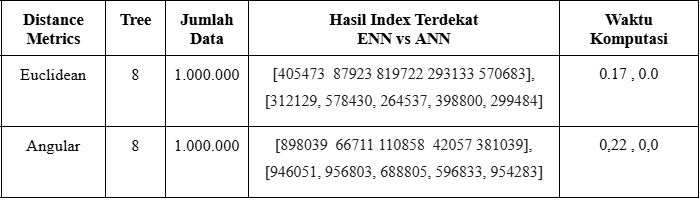

# Praktikum 2

Pada percobaan kali ini kita akan membuat pencarian sederhana menggunakan FAISS. Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.

In [3]:
!pip install faiss-cpu
#!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 58.7 MB/s eta 0:00:00


2 Dimensi

Exact NN (Flat) indices: [[286942 583487 695123]] distances: [[3.4966465e-07 1.0151125e-06 1.2744232e-06]]
IVF+PQ indices: [[286942 695123 581054]] distances: [[4.8242509e-07 2.0805746e-06 2.1811575e-06]]
Waktu Exact: 0.005702972412109375
Waktu IVF+PQ: 0.0010800361633300781


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


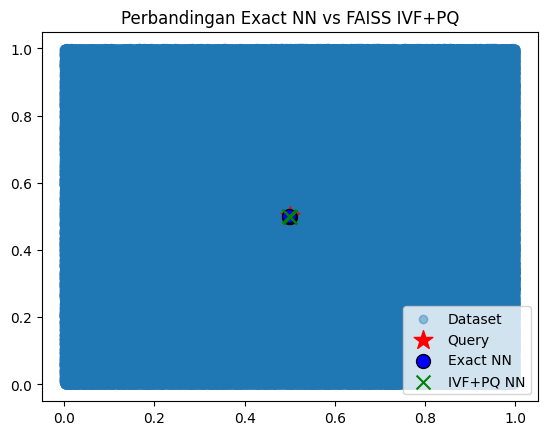

In [6]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()


5 Dimensi

Exact NN (Flat) indices: [901095 495168 561017] distances: [0.00151859 0.00221511 0.00223645]
IVF+PQ indices: [ 7548  9641 18442] distances: [0.02549807 0.02549807 0.02549807]
Waktu Exact: 12.0549 ms
Waktu IVF+PQ: 0.8121 ms


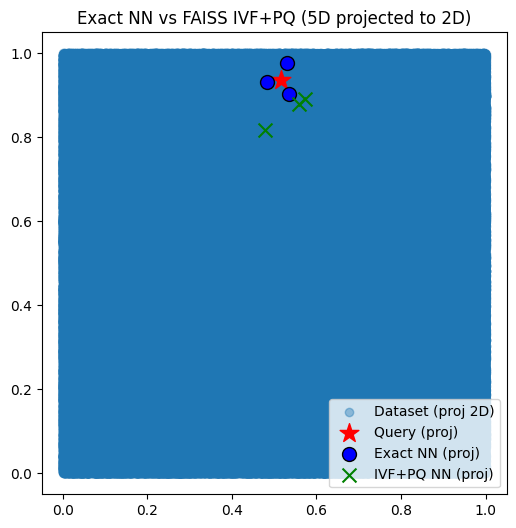

In [8]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 5D
np.random.seed(42)
d = 5
n_points = 1000000
X = np.random.rand(n_points, d).astype('float32')
query = np.random.rand(1, d).astype('float32')  # DIRUBAH: Query 1x5

# 2. Exact NN dengan IndexFlatL2
index_flat = faiss.IndexFlatL2(d)  # DIRUBAH: d=5
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10
m = 1  # DIRUBAH: m=1 agar 5 % 1 == 0
quantizer = faiss.IndexFlatL2(d)  # DIRUBAH: d=5
index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)  # DIRUBAH: d=5

index_ivfpq.train(X)
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat[0], "distances:", D_flat[0])
print("IVF+PQ indices:", I_ivfpq[0], "distances:", D_ivfpq[0])
print("Waktu Exact:", round(time_flat*1000, 4), "ms")
print("Waktu IVF+PQ:", round(time_ivfpq*1000, 4), "ms")

# 5. Visualisasi (proyeksi ke 2D)
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset (proj 2D)")
plt.scatter(query[0,0], query[0,1], c='red', marker='*', s=200, label="Query (proj)")

# Tetangga dari Flat (top 3)
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN (proj)")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN (proj)")

plt.legend()
plt.title("Exact NN vs FAISS IVF+PQ (5D projected to 2D)")
plt.show()  # Atau plt.savefig('plot.png') jika no display

Hasil:
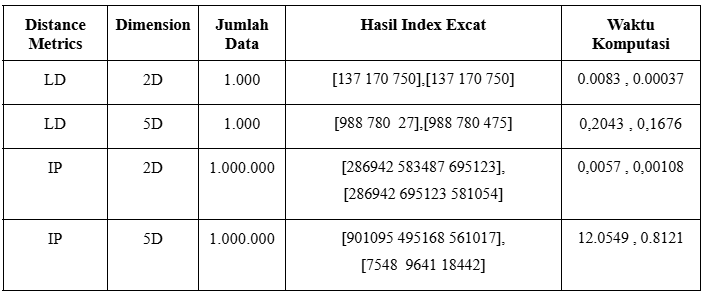

# Praktikum 3

Install hnswlib terlebih dahulu.

In [9]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528147 sha256=db5915b5851f136f3d32f19256a7c5f6a09fd4df89c7907e1fa4e38b6101c1a8
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built hnswlib


Percobaan berikut akan membandingkan exact NN dengan HNSW pada 1000 data 2D.

In [10]:
import hnswlib
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors

# ===========================
# 1. Buat data 2D acak
# ===========================
num_elements = 1000
dim = 2
data = np.random.random((num_elements, dim)).astype(np.float32)

# Query point
query = np.array([[0.5, 0.5]], dtype=np.float32)
k = 5  # cari 5 tetangga terdekat

# ===========================
# 2. Exact NN (Brute Force)
# ===========================
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(data)

start = time.time()
distances, indices = nn.kneighbors(query)
end = time.time()

print("=== Exact NN ===")
print("Indices:", indices)
print("Distances:", distances)
print("Waktu:", end - start, "detik")

# ===========================
# 3. HNSW
# ===========================
# Inisialisasi index HNSW
p = hnswlib.Index(space='l2', dim=dim)

# Ukuran maksimum elemen yang bisa ditampung
p.init_index(max_elements=num_elements, ef_construction=100, M=16)

# Tambahkan data
p.add_items(data)

# Set parameter pencarian
p.set_ef(50)   # tradeoff speed vs accuracy

start = time.time()
labels, distances = p.knn_query(query, k=k)
end = time.time()

print("\n=== HNSW ===")
print("Indices:", labels)
print("Distances:", distances)
print("Waktu:", end - start, "detik")


=== Exact NN ===
Indices: [[993 964 788 528  16]]
Distances: [[0.01145547 0.02310762 0.0234505  0.02675764 0.0279675 ]]
Waktu: 0.09824776649475098 detik

=== HNSW ===
Indices: [[993 964 788 528  16]]
Distances: [[0.00013123 0.00053396 0.00054993 0.00071597 0.00078218]]
Waktu: 0.00032520294189453125 detik


# Praktikum 4

Percobaan kali ini kita akan melihat perbedaan ketiga model yang telah kita bahas dan bandingkan hasilnya.

In [11]:
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

# ===============================
# 1. Buat dataset 1 juta data 5D
# ===============================
n_data = 1_000_000   # bisa coba 100_000 dulu jika RAM terbatas
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# ===============================
# 2. Annoy
# ===============================
print("=== Annoy ===")
ann_index = AnnoyIndex(dim, 'euclidean')

start = time.time()
for i in range(n_data):
    ann_index.add_item(i, X[i])
ann_index.build(10)  # 10 trees
build_time = time.time() - start

start = time.time()
neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", neighbors[0][:5], "...")

# ===============================
# 3. FAISS (Flat Index)
# ===============================
print("\n=== FAISS (IndexFlatL2) ===")
faiss_index = faiss.IndexFlatL2(dim)

start = time.time()
faiss_index.add(X)
build_time = time.time() - start

start = time.time()
distances, indices = faiss_index.search(query, k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", indices[0][:5], "...")

# ===============================
# 4. HNSW (hnswlib)
# ===============================
print("\n=== HNSW (hnswlib) ===")
hnsw_index = hnswlib.Index(space='l2', dim=dim)

start = time.time()
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X)
build_time = time.time() - start

hnsw_index.set_ef(50)

start = time.time()
labels, distances = hnsw_index.knn_query(query, k=k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", labels[0][:5], "...")


=== Annoy ===
Build time: 25.80639100074768 detik
Query time: 0.0002524852752685547 detik
Neighbors: [34547, 796237, 125626, 898723, 758863] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.00979471206665039 detik
Query time: 0.00691986083984375 detik
Neighbors: [ 34547 796237 125626 898723 758863] ...

=== HNSW (hnswlib) ===
Build time: 193.85729718208313 detik
Query time: 0.00029540061950683594 detik
Neighbors: [ 34547 796237 125626 898723 758863] ...


Percobaan dengan matriks berbeda

In [12]:
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

# ===============================
# 1. Buat dataset 1 juta data 5D
# ===============================
n_data = 100_000   # bisa coba 100_000 dulu jika RAM terbatas
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# ===============================
# 2. Annoy
# ===============================
print("=== Annoy ===")
ann_index = AnnoyIndex(dim, 'euclidean')

start = time.time()
for i in range(n_data):
    ann_index.add_item(i, X[i])
ann_index.build(10)  # 10 trees
build_time = time.time() - start

start = time.time()
neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", neighbors[0][:5], "...")

# ===============================
# 3. FAISS (Flat Index)
# ===============================
print("\n=== FAISS (IndexFlatL2) ===")
faiss_index = faiss.IndexFlatL2(dim)

start = time.time()
faiss_index.add(X)
build_time = time.time() - start

start = time.time()
distances, indices = faiss_index.search(query, k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", indices[0][:5], "...")

# ===============================
# 4. HNSW (hnswlib)
# ===============================
print("\n=== HNSW (hnswlib) ===")
hnsw_index = hnswlib.Index(space='l2', dim=dim)

start = time.time()
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X)
build_time = time.time() - start

hnsw_index.set_ef(50)

start = time.time()
labels, distances = hnsw_index.knn_query(query, k=k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", labels[0][:5], "...")


=== Annoy ===
Build time: 1.7297589778900146 detik
Query time: 0.000194549560546875 detik
Neighbors: [95960, 56434, 45934, 27145, 21877] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.0009419918060302734 detik
Query time: 0.0008516311645507812 detik
Neighbors: [95960 56434 45934 27145 21877] ...

=== HNSW (hnswlib) ===
Build time: 13.0191171169281 detik
Query time: 0.00019693374633789062 detik
Neighbors: [95960 56434 45934 27145 21877] ...


# Praktikum 5

Visualisasi dengan grafik sederhana saja yang akan memberikan hasil yang mirip dengan ann benchmark.

# Praktikum 6

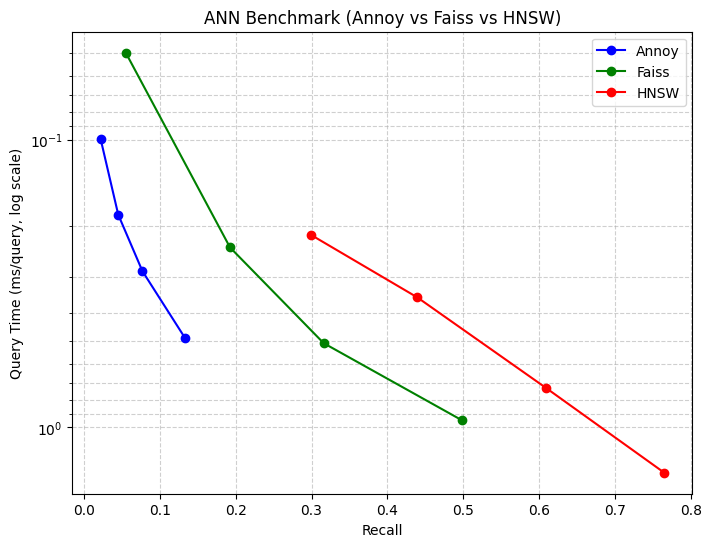

In [16]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

# Praktikum 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv('/content/drive/MyDrive/ML/spotify_song.csv')  # ganti path sesuai lokasi file
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = df[features].values

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact Nearest Neighbor (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=X_scaled.shape[1])
p_hnsw.init_index(max_elements=X_scaled.shape[0], ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, dist_hnsw = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()
quantizer = faiss.IndexFlatL2(X_scaled.shape[1])
index_faiss = faiss.IndexIVFFlat(quantizer, X_scaled.shape[1], nlist=100, metric=faiss.METRIC_L2)
index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10
dist_faiss, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Contoh tampilkan top-5 neighbors dari item pertama
# -------------------------------
print("\nTop-5 neighbors for first song:")
print(f"Exact NN: {idx_exact[0][:5]}")
print(f"Annoy:    {idx_annoy[0][:5]}")
print(f"HNSW:     {idx_hnsw[0][:5]}")
print(f"FAISS:    {idx_faiss[0][:5]}")